# FDRI catchment gauge record vs gridded data at Carreg Wen

The rain gauge record is from Carreg-wen, Pembrokeshire

## Table of contents
[1 Analysis](#1-Analysis)  

In [1]:
import datetime
import numpy as np
import polars as pl
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

# Functions and globals for analysis

In [2]:
def convert_time_to_hour_base(data, hour, time_col='time'):
    """For polars dataframes"""
    return data.with_columns(
                pl.datetime(
                    pl.col(time_col).dt.year(),
                    pl.col(time_col).dt.month(),
                    pl.col(time_col).dt.day(),
                    hour,
                    0,
                    0,
                ).alias(time_col)
            )

In [3]:
RAIN_COL = "rain_mm"
NEARBY_THRESHOLD_M = 2500 # metres
START_DATE = datetime.datetime(year=1976, month=1, day=1, hour=9)
END_DATE = datetime.datetime(year=2010, month=1, day=1, hour=9)
OVERLAP_THRESHOLD = 365*3 # three years

In [170]:
## Severn-wide flood events (from: https://github.com/Thomasjkeel/FDRI-catchment-contribution-to-floods)
severn_flood_dates = ['2000-09-28', '2001-02-13', '2002-01-28', '2002-11-15', '2007-01-01', '2008-03-17','2008-11-11']
severn_flood_dates = [datetime.datetime.strptime(flood_date + ' 09:00', "%Y-%m-%d %H:%M") for flood_date in severn_flood_dates]

# Load data

## Load CEH-GEAR

In [4]:
ceh_plynlimon = xr.open_dataset('../../../CEH_GEAR/ceh_1km_plynlimonregion_19760101_20101231.nc')
ceh_plynlimon = ceh_plynlimon.rename({'rainfall_amount': RAIN_COL})

## Load HadUK-Grid

In [5]:
haduk_plynlimon = xr.open_mfdataset(['../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_plynlimonregion_19760101_19920831.nc',\
                 '../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_plynlimonregion_19920901_20091231.nc'])
haduk_plynlimon = haduk_plynlimon.rename({'rainfall': RAIN_COL, 'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})
haduk_plynlimon = haduk_plynlimon.drop_vars(('latitude', 'longitude'))

## Load Gauge data

In [6]:
## monthly gauges and start and end times
plynlimon_monthly_gauges = pl.read_csv('../gauge_data/mo_monthly_gauges_used.csv', try_parse_dates=True)
plynlimon_monthly_gauges = convert_time_to_hour_base(plynlimon_monthly_gauges, hour=9, time_col='START_DATE')
plynlimon_monthly_gauges = convert_time_to_hour_base(plynlimon_monthly_gauges, hour=9, time_col='END_DATE')

In [7]:
# daily metadata
plynlimon_metadata = pl.read_csv('../gauge_data/mo_plynlimon_area_metadata.csv')
plynlimon_metadata = plynlimon_metadata.with_columns(
    pl.col("ID").is_in(plynlimon_monthly_gauges['ID']).alias('IS_MONTHLY_GAUGE')
)

In [8]:
plynlimon_metadata['IS_MONTHLY_GAUGE'].value_counts()

IS_MONTHLY_GAUGE,count
bool,u32
false,130
true,50


In [9]:
## Load gauge data (QC'd version)
plynlimon_all_gauges = pl.read_csv('../gauge_data/mo_daily_plynlimon_gauges.csv', try_parse_dates=True, new_columns=["gauge_id", "time", f'{RAIN_COL}_gauge', "mo_flag"])
plynlimon_all_gauges = convert_time_to_hour_base(plynlimon_all_gauges, hour=9)

### load new Carreg Wen data

In [117]:
carreg_monthly_gauge = pl.read_csv('../gauge_data/carreg_wen_monthly_92to03.csv', try_parse_dates=True, columns=[1, 2], new_columns=['time', f'{RAIN_COL}_gauge_mon'])
## TODO: set to first day of month
carreg_monthly_gauge = carreg_monthly_gauge.with_columns(
                pl.datetime(
                    pl.col('time').dt.year(),
                    pl.col('time').dt.month(),
                    1,
                    pl.col('time').dt.hour(),
                    pl.col('time').dt.minute(),
                    pl.col('time').dt.second(),
                ).alias('time')
            )
carreg_monthly_gauge.head()

time,rain_mm_gauge_mon
datetime[μs],f64
1992-01-01 00:00:00,173.0
1992-02-01 00:00:00,202.0
1992-03-01 00:00:00,435.0
1992-04-01 00:00:00,222.0
1992-05-01 00:00:00,126.0


In [101]:
carreg_daily_new = pl.read_csv('../gauge_data/plynlimon-jwk-2024-infilled_carreg_rf.csv', skip_lines=13, columns=[0, 1], new_columns=['time', f'{RAIN_COL}_gauge_new'], try_parse_dates=True)
carreg_daily_new.head()

time,rain_mm_gauge_new
datetime[μs],f64
1976-01-02 09:00:00,null
1976-01-03 09:00:00,0.5
1976-01-04 09:00:00,62.0
1976-01-05 09:00:00,12.5
1976-01-06 09:00:00,5.0


# Gauge class required for analysis

In [66]:
ALL_METADATA = plynlimon_metadata
ALL_GAUGE_DATA = plynlimon_all_gauges
CEH_DATA = ceh_plynlimon
HADUK_DATA = haduk_plynlimon

In [67]:
class Gauge:
    def __init__(self, gauge_id):
        self.gauge_id = int(gauge_id)
        self.gauge_metadata = self._get_gauge_metadata()
        self.gauge_easting = self.gauge_metadata['EASTING'].item()
        self.gauge_northing = self.gauge_metadata['NORTHING'].item()
        self.gauge_data = self._get_gauge_data()
        self.nearby_gauges = self._get_nearby_gauges()
        self.closest_cehgear = self._get_closest_gridded_data(CEH_DATA)
        self.closest_haduk = self._get_closest_gridded_data(HADUK_DATA)

    def _get_gauge_metadata(self):
        assert self.gauge_id in ALL_METADATA['ID'],\
            f"Gauge id={self.gauge_id} is not in the gauge metadata"
        return ALL_METADATA.filter(pl.col("ID") == self.gauge_id)

    def _get_gauge_data(self):
        assert self.gauge_id in ALL_GAUGE_DATA['gauge_id'],\
            f"Gauge id={self.gauge_id} is not in the gauge data"
        return ALL_GAUGE_DATA.filter(pl.col("gauge_id") == self.gauge_id)

    def _get_nearby_gauges(self, nearby_threshold_m=NEARBY_THRESHOLD_M):
        nearby_gauge_metadata = ALL_METADATA.filter((pl.col('EASTING') >= self.gauge_easting-nearby_threshold_m)\
                                                & (pl.col('EASTING') <= self.gauge_easting+nearby_threshold_m) &\
            (pl.col('NORTHING') >= self.gauge_northing-nearby_threshold_m) & (pl.col('NORTHING') <= self.gauge_northing+nearby_threshold_m))
        return nearby_gauge_metadata['ID'].to_list()

    def _get_closest_gridded_data(self, gridded_data, closeness_threshold_m=NEARBY_THRESHOLD_M):
        """TODO: needs testing with data that is off grid"""
        closest_grid_cell = gridded_data.sel(x=self.gauge_easting, y=self.gauge_northing, method='nearest')
        distance_x, distance_y = abs(self.gauge_easting-closest_grid_cell['x']), abs(self.gauge_northing-closest_grid_cell['y'])
        if distance_x > closeness_threshold_m or distance_y > closeness_threshold_m:
            raise ValueError(f"Closest data point in grid is more than {closeness_threshold_m} m away in X ({distance_x} m), or Y ({distance_y} m)")
        return closest_grid_cell

    def get_nearby_gridded_data(self, gridded_data, nearby_radius_m=NEARBY_THRESHOLD_M):
        nearby_grid_cells = gridded_data.sel(x=slice(self.gauge_easting-nearby_radius_m, self.gauge_easting+nearby_radius_m),\
                                y=slice(self.gauge_northing-nearby_radius_m, self.gauge_northing+nearby_radius_m))
        return nearby_grid_cells


def get_combined_gauge_data(gauge, how='left'):
    assert isinstance(gauge, Gauge), "data should be of Gauge type"
    closest_ceh = pl.from_pandas(gauge.closest_cehgear[RAIN_COL].drop_vars(('x', 'y')).to_dataframe(f'{RAIN_COL}_closest_ceh').reset_index())
    closest_ceh = convert_time_to_hour_base(closest_ceh, hour=9)
    closest_haduk = pl.from_pandas(gauge.closest_haduk[RAIN_COL].drop_vars(('x', 'y')).to_dataframe(f'{RAIN_COL}_closest_haduk').reset_index())
    closest_haduk = convert_time_to_hour_base(closest_haduk, hour=9)
    combined_data = gauge.gauge_data[['time', f'{RAIN_COL}_gauge']].join(closest_ceh, on='time', how=how)
    combined_data = combined_data.join(closest_haduk, on='time', how=how)
    combined_data = combined_data.sort(by='time')
    return combined_data


def get_combined_gauge_data_w_nearby(gauge, nearby_radius_m=NEARBY_THRESHOLD_M, how='left'):
    combined_data = get_combined_gauge_data(gauge, how=how)
    gauge.nearby_ceh = gauge.get_nearby_gridded_data(CEH_DATA, nearby_radius_m)
    gauge.nearby_haduk = gauge.get_nearby_gridded_data(HADUK_DATA, nearby_radius_m)
    nearby_ceh = pl.from_pandas(gauge.nearby_ceh[RAIN_COL].mean(('x', 'y')).to_dataframe(f'{RAIN_COL}_nearby_ceh').reset_index())
    nearby_ceh = convert_time_to_hour_base(nearby_ceh, hour=9)
    nearby_haduk = pl.from_pandas(gauge.nearby_haduk[RAIN_COL].mean(('x', 'y')).to_dataframe(f'{RAIN_COL}_nearby_haduk').reset_index())
    nearby_haduk = convert_time_to_hour_base(nearby_haduk, hour=9)
    combined_data = combined_data.join(nearby_ceh, on='time', how=how)
    combined_data = combined_data.join(nearby_haduk, on='time', how=how)
    combined_data = combined_data.sort(by='time')
    return combined_data

## Metrics to compare gauge to grid

In [ ]:
## calc_difference
def calc_difference_from_gauge(data, col):
    return data[f'{RAIN_COL}_gauge'] - data[col]

def calc_difference_from_new_gauge(data, col):
    return data[f'{RAIN_COL}_gauge_new'] - data[col]


# Analysis

In [118]:
carreg_gauge = Gauge(420649)

In [119]:
carreg_gauge.gauge_metadata

ID,SRC_ID,NAME,COUNTRY_CODE,EASTING,NORTHING,HYDROMETRIC_AREA,ELEVATION,GEOG_PATH,IS_MONTHLY_GAUGE
i64,i64,str,str,i64,i64,i64,i64,str,bool
420649,9649,"""CARREG WEN""","""GB-GBN""",282900,288500,54,576,"""/BI/UK/GB/WAL/POWN/""",true


In [120]:
carreg_gauge.gauge_data.sort(by='time')

gauge_id,time,rain_mm_gauge,mo_flag
i64,datetime[μs],f64,i64
420649,1973-02-01 09:00:00,0.0,0
420649,1973-02-02 09:00:00,0.7,0
420649,1973-02-03 09:00:00,0.0,0
420649,1973-02-04 09:00:00,0.7,0
420649,1973-02-05 09:00:00,3.8,0
…,…,…,…
420649,1988-10-27 09:00:00,5.7,0
420649,1988-10-28 09:00:00,0.0,0
420649,1988-10-29 09:00:00,0.0,0


In [121]:
carreg_w_nearby = get_combined_gauge_data_w_nearby(carreg_gauge, how='right')
carreg_w_nearby = carreg_w_nearby.sort(by='time')
carreg_w_nearby = carreg_w_nearby.join(carreg_daily_new, on='time') ## join new data
carreg_w_nearby.head()

rain_mm_gauge,rain_mm_closest_ceh,rain_mm_closest_haduk,rain_mm_nearby_ceh,time,rain_mm_nearby_haduk,rain_mm_gauge_new
f64,f64,f64,f64,datetime[μs],f64,f64
33.2,32.8,34.252948,30.846667,1976-01-02 09:00:00,31.655004,null
4.5,4.4,4.645649,4.833333,1976-01-03 09:00:00,4.455749,0.5
41.2,39.5,42.494596,36.693333,1976-01-04 09:00:00,38.621816,62.0
9.2,9.0,9.494617,8.696667,1976-01-05 09:00:00,8.824067,12.5
2.4,2.3,2.469852,2.056667,1976-01-06 09:00:00,2.097106,5.0


In [122]:
carreg_w_nearby_annual_mean = carreg_w_nearby.group_by_dynamic('time', every='1y').agg(pl.all().mean())
carreg_w_nearby_annual_sum = carreg_w_nearby.group_by_dynamic('time', every='1y').agg(pl.all().sum())

carreg_w_nearby_annual_mean.head()

time,rain_mm_gauge,rain_mm_closest_ceh,rain_mm_closest_haduk,rain_mm_nearby_ceh,rain_mm_nearby_haduk,rain_mm_gauge_new
datetime[μs],f64,f64,f64,f64,f64,f64
1976-01-01 00:00:00,4.907182,4.926575,5.13251,4.675032,4.674708,5.061676
1977-01-01 00:00:00,9.466013,7.748767,7.894609,7.280274,7.311171,8.189726
1978-01-01 00:00:00,4.542697,6.888493,7.211537,6.560594,6.567135,7.179452
1979-01-01 00:00:00,null,7.919726,8.194458,7.575315,7.502279,9.094521
1980-01-01 00:00:00,null,7.392623,7.725199,7.046603,7.09663,8.189891


In [123]:
annual_data_dir = {'mean': carreg_w_nearby_annual_mean, 'sum': carreg_w_nearby_annual_sum}
stat_to_examine = 'mean'

In [257]:
columns_for_diff = ['rain_mm_gauge', 'rain_mm_closest_ceh', 'rain_mm_closest_haduk', 'rain_mm_nearby_ceh', 'rain_mm_nearby_haduk']

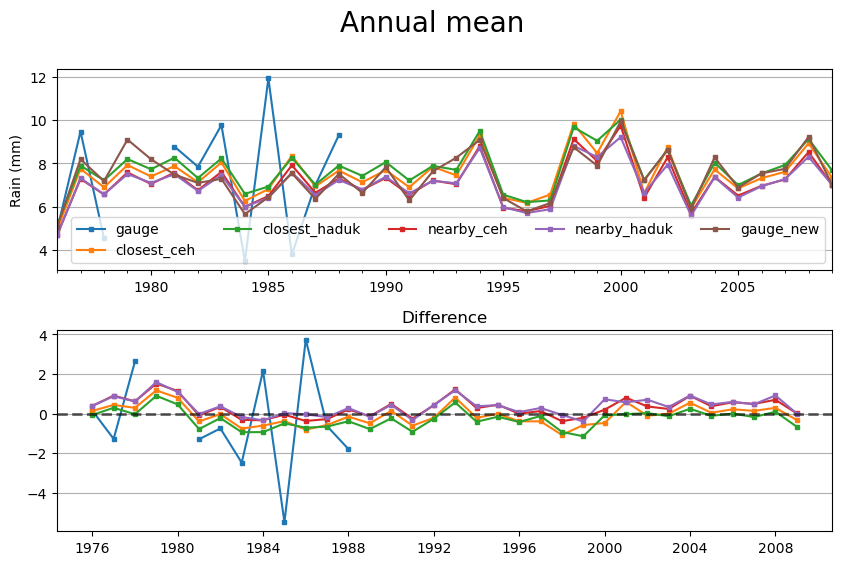

In [259]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
annual_data_df = annual_data_dir[stat_to_examine].to_pandas().set_index('time')
annual_data_df.plot(marker='s', markersize=3, ax=axes[0])
for ind, col in enumerate(columns_for_diff):
    axes[1].plot(calc_difference_from_new_gauge(annual_data_df, col), marker='s', markersize=3, label=col, color=f'C{ind}')

axes[0].legend([col.split('rain_mm_')[-1] for col in annual_data_dir['mean'].columns[1:]], ncols=5)
axes[0].set_ylabel(f"Rain (mm)"); axes[0].set_xlabel('')

axes[1].set_title("Difference")
axes[1].axhline(0, color='k', linewidth=2, alpha=.6, linestyle='--')

for ax in axes:
    ax.grid(axis='y')
plt.suptitle(f"Annual {stat_to_examine}", size=20)
plt.subplots_adjust(hspace=.3)

# fig.savefig(f'../figures/annual_{stat_to_examine}_rainfall_comparison_new_gauge.png', bbox_inches='tight', dpi=200)

### Look at monthly sum

In [277]:
carreg_w_nearby_monthly_sum = carreg_w_nearby.group_by_dynamic('time', every='1mo').agg(pl.all().sum())
carreg_w_nearby_monthly_sum = carreg_w_nearby_monthly_sum.join(carreg_monthly_gauge, on='time', how='left')
carreg_w_nearby_monthly_sum = carreg_w_nearby_monthly_sum.select(['time', 'rain_mm_gauge_new', 'rain_mm_gauge_mon', 'rain_mm_closest_ceh', 'rain_mm_nearby_ceh', 'rain_mm_closest_haduk', 'rain_mm_nearby_haduk'])

In [279]:
carreg_w_nearby_monthly_sum.drop_nulls('rain_mm_gauge_mon')

time,rain_mm_gauge_new,rain_mm_gauge_mon,rain_mm_closest_ceh,rain_mm_nearby_ceh,rain_mm_closest_haduk,rain_mm_nearby_haduk
datetime[μs],f64,f64,f64,f64,f64,f64
1992-01-01 00:00:00,153.5,173.0,163.1,147.3,159.659813,141.978052
1992-02-01 00:00:00,195.5,202.0,189.8,166.176667,181.162753,169.200168
1992-03-01 00:00:00,407.5,435.0,404.7,360.13,394.7983,341.793396
1992-04-01 00:00:00,195.0,222.0,219.1,191.103333,191.013247,181.314376
1992-05-01 00:00:00,125.5,126.0,128.2,122.2,130.565307,121.071048
…,…,…,…,…,…,…
2003-07-01 00:00:00,179.0,200.0,195.9,185.766667,196.989432,181.990562
2003-09-01 00:00:00,104.25,87.7,89.5,84.363333,89.434233,78.496228
2003-10-01 00:00:00,209.25,139.0,148.2,153.353333,201.104988,182.923857


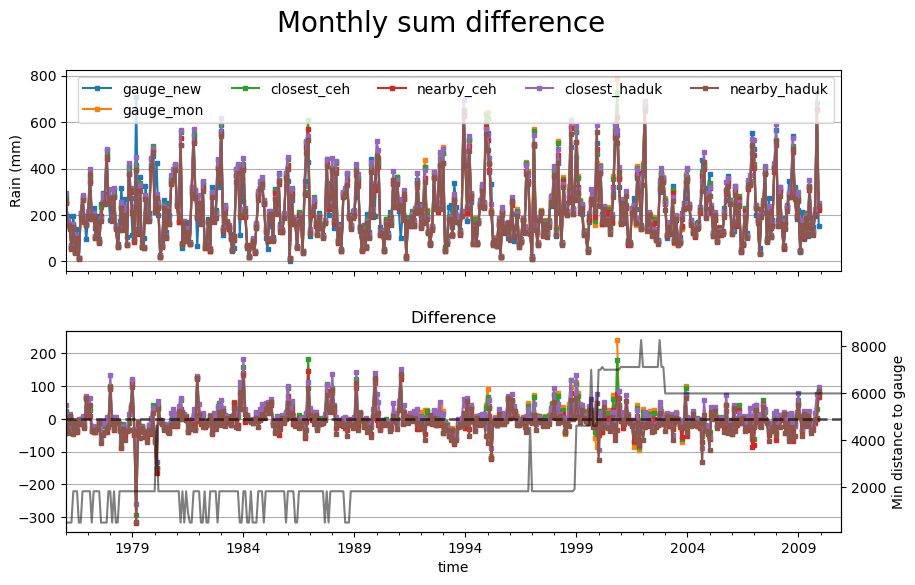

In [414]:
columns_for_diff = carreg_w_nearby_monthly_sum.columns[2:]
carreg_monthly_data_df = carreg_w_nearby_monthly_sum.to_pandas().set_index('time')
carreg_monthly_data_diff_df = carreg_w_nearby_monthly_sum.with_columns(
    pl.all().exclude(('time', f'{RAIN_COL}_gauge_new')) - pl.col(f'{RAIN_COL}_gauge_new')
).drop(f'{RAIN_COL}_gauge_new').to_pandas().set_index('time')

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
carreg_monthly_data_df.plot(marker='s', markersize=3, ax=axes[0])
for ind, col in enumerate(columns_for_diff):
    carreg_monthly_data_diff_df[col].plot(ax=axes[1], marker='s', markersize=3, label=col, color=f'C{ind+1}')

axes[0].legend([col.split('rain_mm_')[-1] for col in carreg_w_nearby_monthly_sum.columns[1:]], ncols=5)
axes[0].set_ylabel(f"Rain (mm)"); axes[0].set_xlabel('')

axes[1].set_title("Difference")
axes[1].axhline(0, color='k', linewidth=2, alpha=.6, linestyle='--')

for ax in axes:
    ax.grid(axis='y')

twin_ax = axes[1].twinx()
carreg_gauge.closest_cehgear['min_dist'].resample(time='MS').mean().to_pandas().plot(ax=twin_ax, alpha=.5, color='k')
twin_ax.set_ylabel("Min distance to gauge")

plt.suptitle(f"Monthly sum difference", size=20)
plt.subplots_adjust(hspace=.3)

# fig.savefig(f'../figures/monthly_{stat_to_examine}_rainfall_comparison_new_gauge.png', bbox_inches='tight', dpi=200)

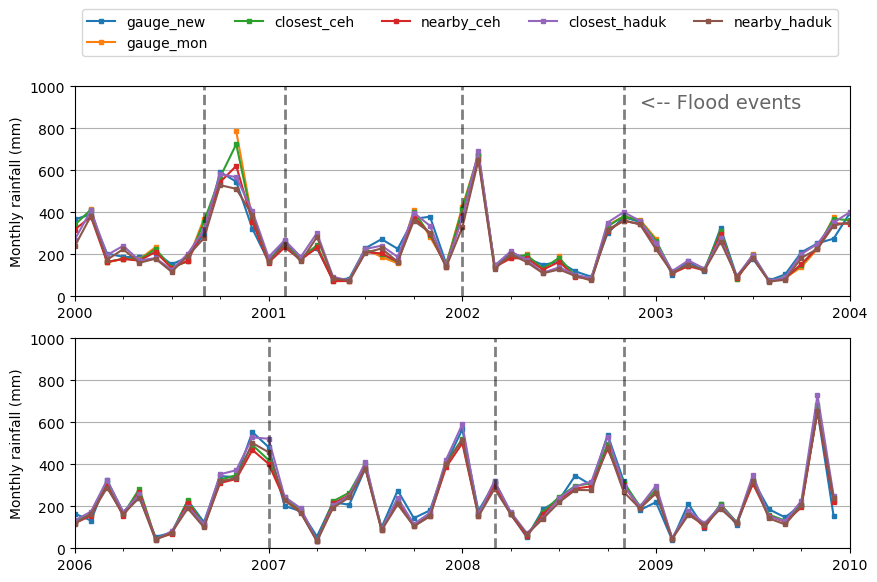

In [ ]:
carreg_monthly_data_df = carreg_w_nearby_monthly_sum.to_pandas().set_index('time')

fig, axes = plt.subplots(2, 1, figsize=(10, 6))
for ax in axes:
    carreg_monthly_data_df.plot(marker='s', markersize=3, ax=ax)
    ax.grid(axis='y')
    ax.set_ylim(0, 1000)
    for flood_date in severn_flood_dates:
        ax.axvline(flood_date, linewidth=2, linestyle='--', color='k', alpha=.5)
    ax.set_ylabel("Monthly rainfall (mm)")
    ax.set_xlabel("")
    # twin_ax = ax.twinx()
    # carreg_gauge.closest_cehgear['min_dist'].resample(time='MS').mean().to_pandas().plot(ax=twin_ax, alpha=.5, color='k')
    # twin_ax.set_ylabel("Min distance to gauge")

axes[0].text(s="<-- Flood events", x="2002-12", y=895, color='k', alpha=.6, size=14)
axes[0].set_xlim("2000", "2004")
axes[0].legend([col.split('rain_mm_')[-1] for col in carreg_w_nearby_monthly_sum.columns[1:]], ncols=5, loc='upper left', bbox_to_anchor=(0, 1.4))
axes[1].set_xlim("2006", "2010")
axes[1].legend().remove()

# fig.savefig(f'../figures/monthly_{stat_to_examine}_carreg_wen_rainfall.png', bbox_inches='tight', dpi=200)

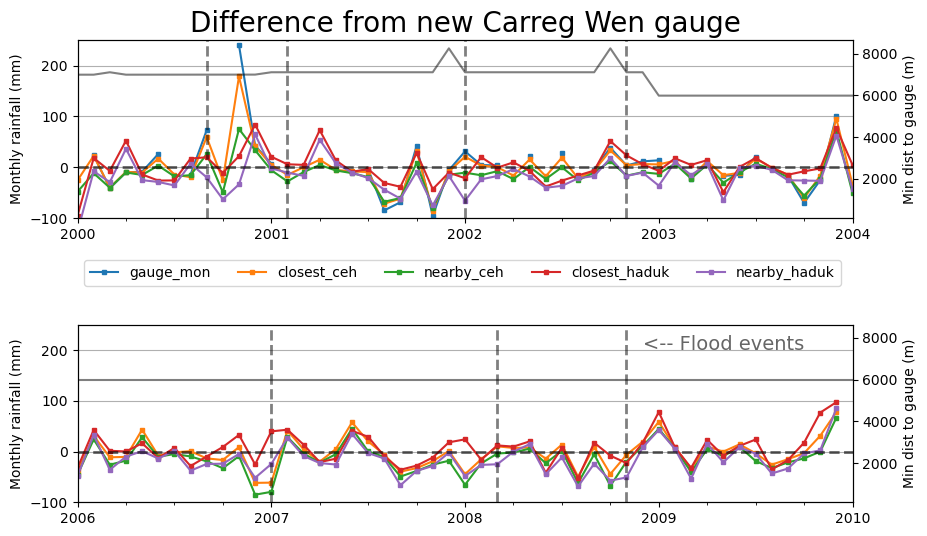

In [ ]:
carreg_monthly_data_diff_df = carreg_w_nearby_monthly_sum.with_columns(
    pl.all().exclude(('time', f'{RAIN_COL}_gauge_new')) - pl.col(f'{RAIN_COL}_gauge_new')
).drop(f'{RAIN_COL}_gauge_new').to_pandas().set_index('time')

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharey=True)
for ax in axes:
    carreg_monthly_data_diff_df.plot(marker='s', markersize=3, ax=ax)

    ax.grid(axis='y')
    for flood_date in severn_flood_dates:
        ax.axvline(flood_date, linewidth=2, linestyle='--', color='k', alpha=.5)
    ax.set_ylabel("Monthly rainfall (mm)")
    ax.set_xlabel("")
    ax.set_ylim(-100, 250)
    ax.axhline(0, color='k', linewidth=2, alpha=.6, linestyle='--')
    twin_ax = ax.twinx()
    carreg_gauge.closest_cehgear['min_dist'].resample(time='MS').mean().to_pandas().plot(ax=twin_ax, alpha=.5, color='k')
    twin_ax.set_ylabel("Min dist to gauge (m)")

axes[0].set_title("Difference from new Carreg Wen gauge", size=20)
axes[1].text(s="<-- Flood events", x="2008-12", y=200, color='k', alpha=.6, size=14)
axes[0].set_xlim("2000", "2004")
axes[0].legend([col.split('rain_mm_')[-1] for col in carreg_monthly_data_diff_df.columns[:]], ncols=5, loc='upper left', bbox_to_anchor=(0, -.2))
axes[1].set_xlim("2006", "2010")
axes[1].legend().remove()
plt.subplots_adjust(hspace=.6)

# fig.savefig(f'../figures/monthly_{stat_to_examine}_carreg_wen_rainfall_diff.png', bbox_inches='tight', dpi=200)



## double mass plot

In [430]:
carreg_w_nearby_cumsum = carreg_w_nearby.with_columns(
    pl.all().exclude("time").cum_sum()
)
carreg_w_nearby_cumsum.tail()

rain_mm_gauge,rain_mm_closest_ceh,rain_mm_closest_haduk,rain_mm_nearby_ceh,time,rain_mm_nearby_haduk,rain_mm_gauge_new
f64,f64,f64,f64,datetime[μs],f64,f64
null,93118.8,95406.159002,88271.196667,2009-12-27 09:00:00,87487.94564,92069.25
null,93119.1,95406.823589,88271.496667,2009-12-28 09:00:00,87488.572105,92070.25
null,93139.8,95430.208107,88290.98,2009-12-29 09:00:00,87510.769343,92070.25
null,93152.8,95444.118615,88303.376667,2009-12-30 09:00:00,87524.00059,92070.25
null,93152.8,95444.163795,88303.376667,2009-12-31 09:00:00,87524.041041,92070.25


In [434]:
var_to_examine, data_to_examine = '1cell', 'cehgear'
x_var = f'{RAIN_COL}_closest_ceh'
y_var = f'{RAIN_COL}_closest_haduk'

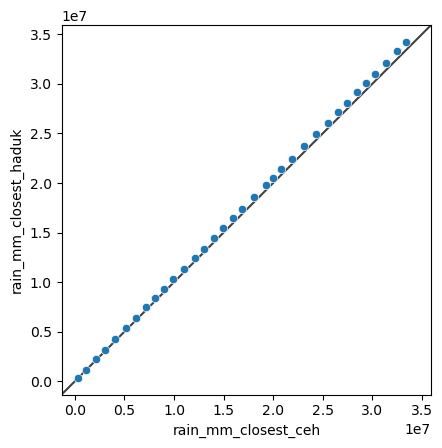

In [436]:
#  = carreg_rain_data_cumsum.group_by_dynamic('time', every='1y').agg(pl.all().sum())
data_to_plot = carreg_w_nearby_cumsum.group_by_dynamic('time', every='12mo').agg(pl.all().sum())

fig, ax = plt.subplots(1)
sns.scatterplot(x=x_var, y=y_var, data=data_to_plot, ax=ax)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

# fig.savefig('../figures/double_mass_cehgear_gauge_annual.png', bbox_inches='tight', dpi=200)

## Look at flood events

In [461]:
DAYS_BEFORE_FLOOD = 10

In [462]:
def get_date_ndays_before(one_date, ndays):
    return one_date-datetime.timedelta(days=ndays)

In [463]:
def get_data_ndays_before_flood_date(data, flood_date, ndays):
    days_before = get_date_ndays_before(flood_date, ndays=ndays)
    return data.filter(
        (pl.col("time") >= days_before) & (pl.col("time") <= flood_date)
    )

In [470]:
carreg_w_nearby_for_flooding = carreg_w_nearby.select(['time', 'rain_mm_gauge_new','rain_mm_closest_ceh', 'rain_mm_nearby_ceh', 'rain_mm_closest_haduk', 'rain_mm_nearby_haduk'])

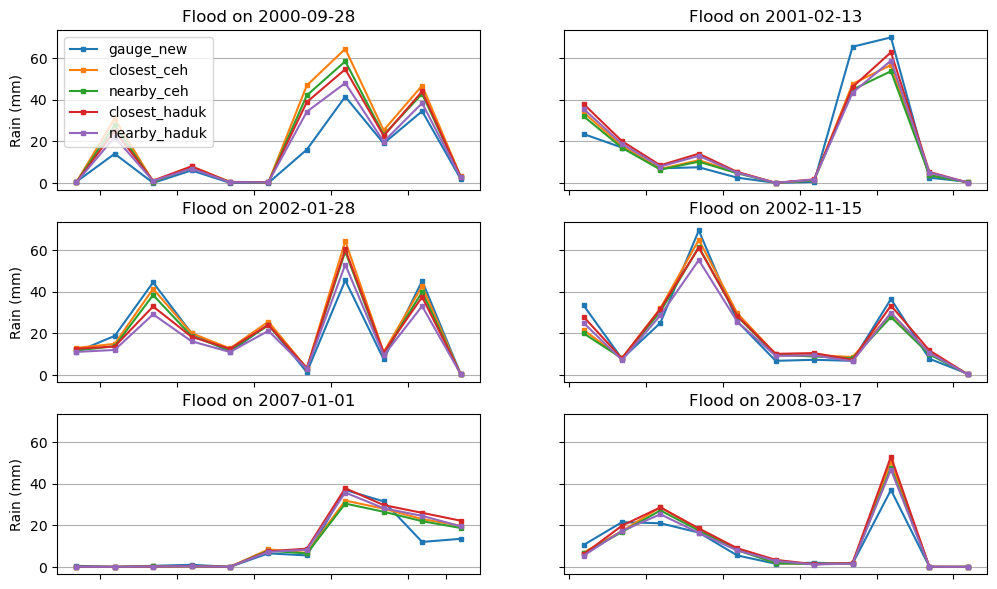

In [471]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharey=True)
for ind, ax in enumerate(axes.flatten()):
    if ind == 0:
        get_data_ndays_before_flood_date(carreg_w_nearby_for_flooding, severn_flood_dates[ind], ndays=DAYS_BEFORE_FLOOD ).to_pandas().set_index('time').plot(ax=ax, marker='s', markersize=3)
        ax.legend([col.split('rain_mm_')[-1] for col in carreg_w_nearby_for_flooding.columns[1:]])
    else:
        get_data_ndays_before_flood_date(carreg_w_nearby_for_flooding, severn_flood_dates[ind], ndays=DAYS_BEFORE_FLOOD ).to_pandas().set_index('time').plot(ax=ax, marker='s', markersize=3, legend=False)
    ax.set_title(f"Flood on {severn_flood_dates[ind].strftime('%Y-%m-%d')}")
    ax.set_xticklabels((''));
    ax.set_xlabel('')
    ax.set_ylabel('Rain (mm)')
    ax.grid(axis='y')
# fig.savefig('../figures/six_flood_comparison.png', bbox_inches='tight', dpi=200)

In [475]:
all_summed_rain_for_flood_events = {}
for flood_date in severn_flood_dates:
    all_summed_rain_for_flood_events[flood_date] = get_data_ndays_before_flood_date(carreg_w_nearby_for_flooding, flood_date, ndays=DAYS_BEFORE_FLOOD).sum()

In [494]:
all_summed_rain_for_flood_events_df = pl.concat(all_summed_rain_for_flood_events.values())
all_summed_rain_for_flood_events_df = all_summed_rain_for_flood_events_df.with_columns(time=np.array([dt.date().strftime('%Y-%m-%d') for dt in severn_flood_dates]))

In [495]:
all_summed_rain_for_flood_events_df

time,rain_mm_gauge_new,rain_mm_closest_ceh,rain_mm_nearby_ceh,rain_mm_closest_haduk,rain_mm_nearby_haduk
str,f64,f64,f64,f64,f64
"""2000-09-28""",133.5,227.1,205.713333,198.118892,173.701007
"""2001-02-13""",196.5,184.1,173.933333,201.891936,189.001856
"""2002-01-28""",229.5,249.1,230.696667,226.61166,199.44312
"""2002-11-15""",227.0,224.7,212.503333,230.384364,207.278125
"""2007-01-01""",108.0,118.3,112.39,132.719379,124.120672
"""2008-03-17""",117.0,135.2,128.52,141.490395,124.690627
"""2008-11-11""",87.5,119.4,112.756667,117.569226,105.70558


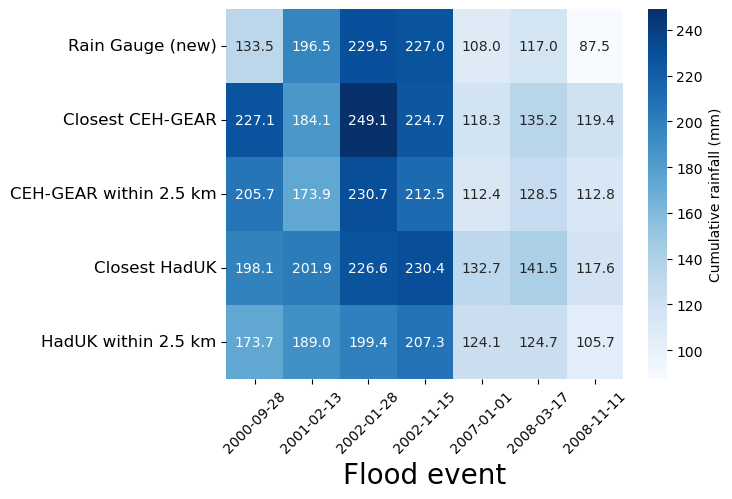

In [ ]:
fig, ax = plt.subplots(1)
sns.heatmap(all_summed_rain_for_flood_events_df.to_pandas().set_index('time').T, fmt='.1f', annot=True, cmap='Blues', ax=ax, cbar_kws={'label': 'Cumulative rainfall (mm)'})
ax.set_yticklabels(['Rain Gauge (new)', 'Closest CEH-GEAR', f'CEH-GEAR within {NEARBY_THRESHOLD_M/1000} km', 'Closest HadUK', f'HadUK within {NEARBY_THRESHOLD_M/1000} km'], size=12);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel("Flood event", size=20)
# fig.savefig('../figures/six_flood_comparison_heatmap.png', bbox_inches='tight', dpi=200)

## Spatial variation of HADUK

In [443]:
CARREG_COORDS = {'Easting': carreg_gauge.gauge_easting, 'Northing': carreg_gauge.gauge_northing}

In [444]:
dataset_dir = {'CEH-GEAR': ceh_plynlimon, 'HadUK-Grid': haduk_plynlimon}
dataset_to_examine = 'CEH-GEAR'

In [445]:
def plot_3by3_heatmap_mean_std(dataset, axes_row):
    dataset[RAIN_COL].mean('time').plot(cmap='Blues', ax=axes_row[0])
    axes_row[0].plot(CARREG_COORDS['Easting'], CARREG_COORDS['Northing'], 'ro')
    axes_row[0].set_title('mean')

    dataset[RAIN_COL].std('time').plot(cmap='Purples', ax=axes_row[1])
    axes_row[1].plot(CARREG_COORDS['Easting'], CARREG_COORDS['Northing'], 'ro')
    axes_row[1].set_title('stdev')

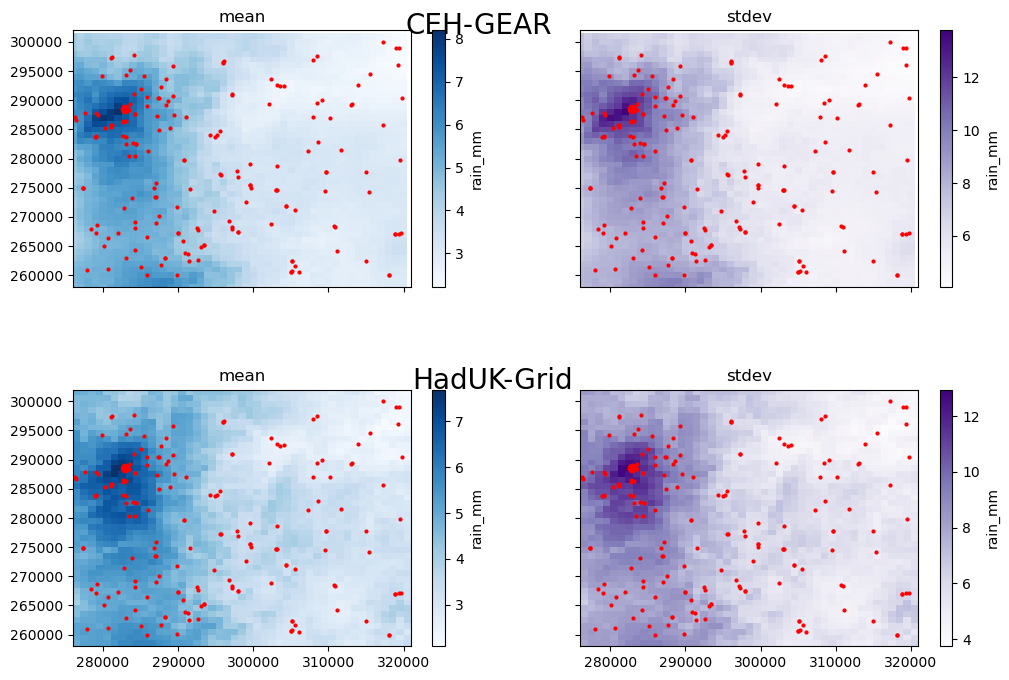

In [447]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
plot_3by3_heatmap_mean_std(dataset_dir['CEH-GEAR'], axes_row=axes[0])
plot_3by3_heatmap_mean_std(dataset_dir['HadUK-Grid'], axes_row=axes[1])

for ax in axes.flatten():
    ax.set_xlabel(''); ax.set_ylabel('')

axes[0][0].text(s='CEH-GEAR', x=dataset_dir['CEH-GEAR']['x'].max()+300,\
                              y=dataset_dir['CEH-GEAR']['y'].max()+300,\
                                size=20)

axes[1][0].text(s='HadUK-Grid', x=dataset_dir['HadUK-Grid']['x'].max()+700,\
                              y=dataset_dir['HadUK-Grid']['y'].max()+700,\
                                size=20)

for ax in axes.flatten():
  for plyn_row in plynlimon_metadata.iter_rows(named=True):
    ax.plot(plyn_row['EASTING'], plyn_row['NORTHING'], 'ro', markersize=2)

plt.subplots_adjust(hspace=.4)
# fig.savefig('../figures/ceh_vs_haduk_grid_comparison.png', bbox_inches='tight', dpi=200)